# Options Portfolio Optimization

In [1]:
import numpy as np
import pandas as pd

from typing import Dict
from numpy.typing import NDArray

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, roc_auc_score

import xgboost as xgb

from scipy.optimize import minimize

import yfinance as yf
from py_vollib.black_scholes_merton.greeks.analytical import delta, theta, gamma, vega, rho

In [2]:
TICKER : str = "INTC"
RISK_FREE_RATE_TICKER : str = "^IRX"
PERIOD_YEARS : int = 5
YF_PERIOD_STR : str = f"{PERIOD_YEARS}y"

## Preprocessing

In [3]:
# Load and reformat options chain history
raw_options_df = pd.read_csv("tech-options-chains.csv", parse_dates=["date", "expiration"])

raw_options_df = raw_options_df.rename(
    {"act_symbol": "symbol",
     "call_put": "type"},
    axis = 1
)

raw_options_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003146 entries, 0 to 1003145
Data columns (total 13 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   date        1003146 non-null  datetime64[ns]
 1   symbol      1003146 non-null  object        
 2   expiration  1003146 non-null  datetime64[ns]
 3   strike      1003146 non-null  float64       
 4   type        1003146 non-null  object        
 5   bid         1003146 non-null  float64       
 6   ask         1003146 non-null  float64       
 7   vol         1003146 non-null  float64       
 8   delta       1003146 non-null  float64       
 9   gamma       1003146 non-null  float64       
 10  theta       1003146 non-null  float64       
 11  vega        1003146 non-null  float64       
 12  rho         1003146 non-null  float64       
dtypes: datetime64[ns](2), float64(9), object(2)
memory usage: 99.5+ MB


In [ ]:
# Restrict chain ticker and dates
end_date = raw_options_df["date"].max()
latest_start_date = end_date -  pd.Timedelta(days=365 * PERIOD_YEARS)
start_date = raw_options_df[raw_options_df["date"] < latest_start_date]["date"].max()

options_df = raw_options_df[(raw_options_df["date"] >= start_date) & (raw_options_df["date"] <= end_date)]
options_df = options_df[options_df["symbol"] == TICKER]

# Create useful columns
options_df["unique_symbol"] = (
    options_df["symbol"] +
    options_df["expiration"].dt.strftime("%Y%m%d") +
    options_df["type"].str[0] +
    options_df["strike"].astype(str)
)

options_df["mid_price"] = (options_df["bid"] + options_df["ask"]) / 2

options_df["spread"] = options_df["ask"] - options_df["bid"]

options_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96510 entries, 522 to 902113
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           96510 non-null  datetime64[ns]
 1   symbol         96510 non-null  object        
 2   expiration     96510 non-null  datetime64[ns]
 3   strike         96510 non-null  float64       
 4   type           96510 non-null  object        
 5   bid            96510 non-null  float64       
 6   ask            96510 non-null  float64       
 7   vol            96510 non-null  float64       
 8   delta          96510 non-null  float64       
 9   gamma          96510 non-null  float64       
 10  theta          96510 non-null  float64       
 11  vega           96510 non-null  float64       
 12  rho            96510 non-null  float64       
 13  unique_symbol  96510 non-null  object        
 14  mid_price      96510 non-null  float64       
 15  spread         96510 

In [5]:
# Load stock data
stock = yf.Ticker(TICKER)
risk_free = yf.Ticker(RISK_FREE_RATE_TICKER)

# Stock starts one year earlier to compute annualized dividend
stock_df = stock.history(start = start_date - pd.Timedelta(days = 366), end = end_date + pd.Timedelta(days = 1))
risk_free_df = risk_free.history(start = start_date, end = end_date)

In [6]:
# Prepare stock and treasury data for merge
stock_close = stock_df[["Close"]].reset_index()
stock_close = stock_close.rename({"Close": "stock"}, axis = 1)

risk_free_close = risk_free_df[["Close"]].reset_index()
risk_free_close = risk_free_close.rename({"Close": "risk-free"}, axis = 1)

# Prevent times from interfering with merge
stock_close["Date"] = pd.to_datetime(stock_close["Date"].apply(lambda x: x.date()))
risk_free_close["Date"] = pd.to_datetime(risk_free_close["Date"].apply(lambda x: x.date()))

# Merge
combined_close = stock_close.merge(risk_free_close, on="Date", how="inner")
combined_close = combined_close.rename({"Date": "date"})
combined_close = combined_close.set_index("Date")

In [7]:
# Reindex to all days and cut off outside of range
full_date_range = pd.date_range(
    start = combined_close.index.min(),
    end = options_df["date"].max(),
    freq = "D"
)

combined_close = combined_close.reindex(full_date_range).ffill()

In [8]:
# Compute annualized dividends
long_date_range = pd.date_range(
    start = combined_close.index.min() - pd.Timedelta(days = 365),
    end = options_df["date"].max(),
    freq = "D"
)

dividends = stock_df["Dividends"].reset_index()
dividends["Date"] = pd.to_datetime(dividends["Date"].apply(lambda x: x.date()))
dividends = dividends.set_index("Date").reindex(long_date_range)["Dividends"].fillna(0)

simple_yield = dividends.rolling(window=365).sum() / combined_close["stock"]
continuous_yield = np.log(1 + simple_yield)

In [9]:
def compute_greeks(options_df_row: pd.Series) -> dict[str, float]:
    date = options_df_row["date"]
    combined_close_row = combined_close.loc[date]
    trailing_year_dividends = continuous_yield.loc[date]

    greek_inputs = {
        "flag": options_df_row["type"][0].lower(), # Always "c" or "p"
        "S": combined_close_row["stock"],
        "K": options_df_row["strike"],
        "t": (options_df_row["expiration"] - date).days / 365,
        "r": combined_close_row["risk-free"] / 100, # Divide because ^IRX is in %
        "sigma": options_df_row["vol"],
        "q": trailing_year_dividends
    }

    return {
        "delta": delta(**greek_inputs),
        "gamma": gamma(**greek_inputs),
        "theta": theta(**greek_inputs),
        "vega": vega(**greek_inputs),
        "rho": rho(**greek_inputs)
    }


In [10]:
def create_inputs(options_df_row: pd.Series) -> dict[str, float]:
    date = options_df_row["date"]
    combined_close_row = combined_close.loc[date]

    ans = compute_greeks(options_df_row)

    ans["dte"] = (options_df_row["expiration"] - options_df_row["date"]).days
    ans["moneyness"] = (options_df_row["strike"] / combined_close_row["stock"])

    return ans

In [11]:
# Create inputs
input_df = options_df.apply(create_inputs, axis=1)
input_df = pd.DataFrame(input_df.to_list(), index = options_df.index)

# Create targets
target_df = options_df.sort_values(by=["unique_symbol", "date"])
target_df["next_day_return"] = target_df.groupby("unique_symbol")["mid_price"].pct_change().shift(-1)

/opt/anaconda3/envs/quant/lib/python3.13/site-packages/py_vollib/ref_python/black_scholes_merton/__init__.py:87: RuntimeWarning: divide by zero encountered in scalar divide
  return numerator / denominator
/opt/anaconda3/envs/quant/lib/python3.13/site-packages/py_vollib/black_scholes_merton/greeks/analytical.py:210: RuntimeWarning: invalid value encountered in scalar divide
  return numerator / denominator


In [12]:
# Create unified dataset
df = pd.merge(
    left = input_df.reset_index(),
    right = target_df.reset_index().drop(columns = ["delta", "gamma", "theta", "vega", "rho"]),
    on="index"
).dropna().drop(columns = ["index"]).sort_values(by = "date")

df.head()

,delta,gamma,theta,vega,rho,dte,moneyness,date,symbol,expiration,strike,type,bid,ask,vol,unique_symbol,mid_price,spread,next_day_return
96509,-0.979505,0.005380,-0.005947,0.007133,-0.098655,56,1.441303,2020-07-24,INTC,2020-09-18,65.0,Put,14.80,15.15,0.4249,INTC20200918P65.0,14.975,0.35,0.060100
96428,0.009248,0.004522,-0.004861,0.002198,0.000154,14,1.341520,2020-07-24,INTC,2020-08-07,60.5,Call,0.05,0.11,0.6231,INTC20200807C60.5,0.080,0.06,-0.562500
96429,-0.989671,0.004522,-0.008179,0.002198,-0.023051,14,1.341520,2020-07-24,INTC,2020-08-07,60.5,Put,10.20,10.65,0.6231,INTC20200807P60.5,10.425,0.45,0.083933
96430,0.002883,0.001726,-0.001602,0.000780,0.000048,14,1.374781,2020-07-24,INTC,2020-08-07,62.0,Call,0.06,0.10,0.5788,INTC20200807C62.0,0.080,0.04,-0.500000
96431,-0.992270,0.003281,-0.007065,0.001644,-0.023669,14,1.374781,2020-07-24,INTC,2020-08-07,62.0,Put,11.65,12.10,0.6424,INTC20200807P62.0,11.875,0.45,0.080000


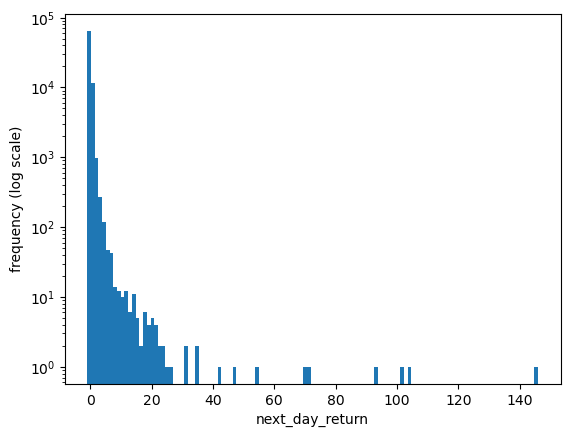

-0.9291916939586091 3.3738815789473806


In [13]:
plt.hist(df["next_day_return"][df["next_day_return"] < np.inf], bins = 121, log=True)
plt.xlabel("next_day_return")
plt.ylabel("frequency (log scale)")
plt.show()

print(df["next_day_return"].quantile(0.005), df["next_day_return"].quantile(0.995))

In [14]:
# Clip bad next_day_returns
MIN_RETURN = -0.92
MAX_RETURN = 3

df = df[(df["next_day_return"] > MIN_RETURN) & (df["next_day_return"] < MAX_RETURN)]

In [15]:
# Create model-ready data
features = ["dte", "moneyness", "vol", "delta", "gamma", "theta", "vega", "rho"]
target = "next_day_return"

X = df[features]
y = df[target]

split_point = int(0.8 * len(df))

X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

y_train_class = (y_train > 0).astype(int)
y_test_class = (y_test > 0).astype(int)

print(f"Training from {df["date"].min().date()} to {df["date"].iloc[split_point - 1].date()}")
print(f"Testing from {df["date"].iloc[split_point].date()} to {df["date"].max().date()}")

Training from 2020-07-24 to 2024-11-11
Testing from 2024-11-11 to 2025-07-23


## Modeling

### Ridge Regression

In [16]:
ridge_model = Ridge(alpha=1)
ridge_model.fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)

print(f"Test MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Test R^2: {r2_score(y_test, y_pred):.4f}")

Test MSE: 0.1512
Test R^2: 0.0004


In [17]:
alphas = np.logspace(-6, 6, 13)

time_cv = TimeSeriesSplit(n_splits=5)

ridge_cv_model = RidgeCV(
    alphas=alphas,
    cv=time_cv,
    scoring="neg_mean_squared_error"
)
ridge_cv_model.fit(X_train, y_train)

y_pred = ridge_cv_model.predict(X_test)

print(f"Best alpha: {ridge_cv_model.alpha_}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Test R^2: {r2_score(y_test, y_pred):.4f}")

Best alpha: 1000000.0
Test MSE: 0.1517
Test R^2: -0.0030


### XGBoost Regression

In [18]:
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=42
)

xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

y_pred = xgb_model.predict(X_test)

print(f"Test MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Test R^2: {r2_score(y_test, y_pred):.4f}")

Test MSE: 0.1659
Test R^2: -0.0969


### XGBoost Classification

In [19]:
neg_count = y_train_class.value_counts()[0]
pos_count = y_train_class.value_counts()[1]
scale_pos_weight_value = neg_count / pos_count

xgb_classifier = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    scale_pos_weight=scale_pos_weight_value,
    n_jobs=-1,
    random_state=42
)

xgb_classifier.fit(
    X_train,
    y_train_class,
    eval_set=[(X_test, y_test_class)],
    verbose=False
)

y_pred_proba = xgb_classifier.predict_proba(X_test)[:, 1]
y_pred_class = (y_pred_proba > 0.5).astype(int)

print(f"Accuracy: {accuracy_score(y_test_class, y_pred_class):.4f}")
print(f"Precision: {precision_score(y_test_class, y_pred_class):.4f}")
print(f"Recall: {recall_score(y_test_class, y_pred_class):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test_class, y_pred_proba):.4f}")

Accuracy: 0.4799
Precision: 0.4028
Recall: 0.6857
ROC AUC: 0.5245


In [20]:
results_df = pd.DataFrame({
    "true_label": y_test_class,
    "predicted_probability": y_pred_proba
})

thresholds = np.arange(0.5, 0.9, 0.01)

analysis_results = []

for threshold in thresholds:
    confident_predictions = results_df[results_df["predicted_probability"] > threshold]

    num_predictions = len(confident_predictions)

    if num_predictions == 0:
        precision = 0
    else:
        correct_positive_predictions = confident_predictions["true_label"].sum()
        precision = correct_positive_predictions / num_predictions

    analysis_results.append({
        "confidence_threshold": threshold,
        "precision": precision,
        "num_trades": num_predictions,
        "coverage_pct": (num_predictions / len(results_df)) * 100,
    })

threshold_analysis_df = pd.DataFrame(analysis_results)
threshold_analysis_df.tail(5)

,confidence_threshold,precision,num_trades,coverage_pct
35,0.85,0.470588,17,0.110540
36,0.86,0.437500,16,0.104038
37,0.87,0.400000,10,0.065024
38,0.88,0.428571,7,0.045517
39,0.89,0.428571,7,0.045517


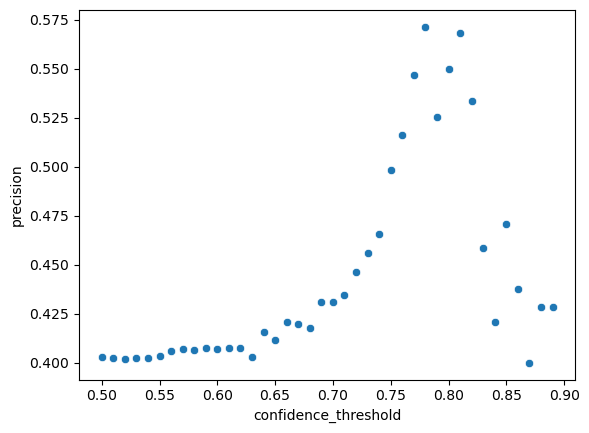

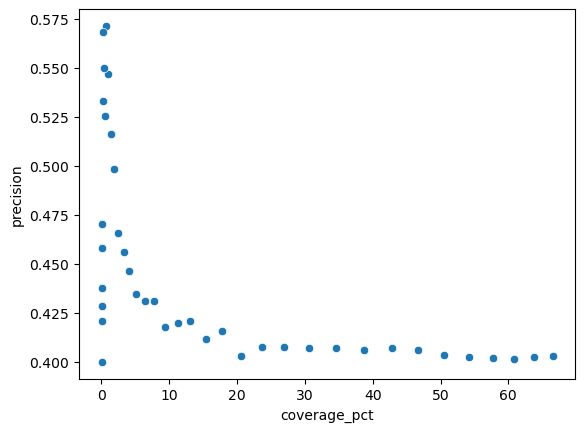

In [21]:
sns.scatterplot(
    threshold_analysis_df[threshold_analysis_df["num_trades"] > 0],
    x = "confidence_threshold",
    y = "precision"
)
plt.show()

sns.scatterplot(
    threshold_analysis_df[threshold_analysis_df["num_trades"] > 0],
    x = "coverage_pct",
    y = "precision"
)
plt.show()

## Optimization

In [22]:
def objective_function(weights: NDArray[np.float32], probs: NDArray[np.float32],
                       cov_matrix: NDArray[np.float32], risk_aversion: float) -> float:
    ev_estimate = np.dot(weights, probs)
    var_estimate = np.dot(weights.T, np.dot(cov_matrix, weights))

    utility = ev_estimate - var_estimate * risk_aversion

    return -utility

In [23]:
def run_optimizer(probabilities: pd.Series, cov_matrix: pd.DataFrame,
                  risk_aversion: float = 10.0, verbose: bool = False) -> NDArray[np.float32]:
    n_assets = len(probabilities)

    if n_assets == 0:
        return np.array([], dtype = np.float32)

    x_uniform = np.array([1/n_assets] * n_assets)

    result = minimize(
        fun = objective_function,
        x0 = x_uniform, # Initial guess of uniform allocation
        args = (probabilities, cov_matrix, risk_aversion),
        method = "SLSQP",
        bounds = tuple((0, 1) for _ in range(n_assets)),
        constraints = ({"type": "eq", "fun": lambda w: np.sum(w) - 1}, )
    )

    if result.success:
        return result.x
    else:
        if verbose:
            print("Optimization failed")
        
        return result.x

In [24]:
def recommend(date: str, confidence_cutoff: float,
              min_history: int = 5) -> Dict[str, float]:
    # Create slice and window
    input_slice = df[df["date"] == date]
    input_window = df[df["date"] <= date]

    # Restrict window to available symbols
    input_slice = input_slice[input_slice["dte"] > 0]
    input_window = input_window[input_window["unique_symbol"].isin(input_slice["unique_symbol"].unique())]

    # Remove if insufficient history
    value_counts = input_window["unique_symbol"].value_counts()
    candidate_symbols = value_counts[value_counts >= min_history].index

    input_window = input_window[input_window["unique_symbol"].isin(candidate_symbols)]
    input_slice = input_slice[input_slice["unique_symbol"].isin(candidate_symbols)]

    if len(input_slice) == 0:
        return {}

    # Keep only high confidence
    probabilities = pd.Series(
        index = input_slice["unique_symbol"],
        data = xgb_classifier.predict_proba(input_slice[features])[:, 1]
    )
    candidate_symbols = probabilities[probabilities > confidence_cutoff].index

    if len(candidate_symbols) == 0:
        return {}

    input_window = input_window[input_window["unique_symbol"].isin(candidate_symbols)]
    cov_matrix = input_window.pivot(index = "date", columns = "unique_symbol", values = "next_day_return").cov()

    # Align probabilities with cov_matrix columns
    opt_probabilities = probabilities[cov_matrix.columns]

    # Run optimizer
    weights = run_optimizer(opt_probabilities, cov_matrix, 10)
    
    return dict(zip(cov_matrix.columns, weights.tolist()))

### Testing

In [25]:
date_ = "2025-02-21"
confidence_cutoff_ = 0.75

input_slice_ = df[df["date"] == date_] # Get all options for the date
input_window_ = df[df["date"] <= date_] # Get all options on or before the date
input_window_ = input_window_[input_window_["unique_symbol"].isin(input_slice_["unique_symbol"].unique())] # Keep only tradable options

value_counts_ = input_window_["unique_symbol"].value_counts()
candidate_symbols_ = value_counts_[value_counts_ >= 5].index # Keep only options with at least 5 days of history

input_window_ = input_window_[input_window_["unique_symbol"].isin(candidate_symbols_)] # Create clean window
input_slice_ = input_slice_[input_slice_["unique_symbol"].isin(candidate_symbols_)] # Create clean slice

In [26]:
# Checks
assert(input_window_["unique_symbol"].value_counts().min() >= 5)
assert(input_window_["unique_symbol"].isin(input_slice_["unique_symbol"].unique()).mean() == 1)

In [27]:
probabilities_ = pd.Series(
    index = input_slice_["unique_symbol"],
    data = xgb_classifier.predict_proba(input_slice_[features])[:, 1]
)
candidate_symbols_ = probabilities_[probabilities_ > confidence_cutoff_].index

In [28]:
input_window_ = input_window_[input_window_["unique_symbol"].isin(candidate_symbols_)]
cov_matrix_ = input_window_.pivot(index = "date", columns = "unique_symbol", values = "next_day_return").cov()
cov_matrix_

unique_symbol
unique_symbol


In [29]:
index_ = cov_matrix_.columns
opt_probabilities_ = probabilities_[index_]

In [30]:
results_ = run_optimizer(opt_probabilities_, cov_matrix_, 10)

In [31]:
{index_[i]: results_[i].item() for i in range(len(index_))}

{}

## Backtesting

In [32]:
CONFIDENCE_CUTOFF = 0.8

In [33]:
trading_days = sorted(df["date"].unique())

portfolio_returns_log = []

for date in trading_days:
    # Today's weights
    todays_weights = recommend(
        date = date.strftime("%Y-%m-%d"),
        confidence_cutoff = CONFIDENCE_CUTOFF
    )
    
    if not todays_weights:
        daily_return = 0
    else:
        symbols_held = list(todays_weights.keys())

        # Dataset provides next day returns in today's row, so we immediately know results
        todays_returns = df[
            (df["date"] == date) &
            (df["unique_symbol"].isin(symbols_held))
        ].set_index("unique_symbol")["next_day_return"]

        # Align returns with weights
        aligned_returns = todays_returns.reindex(symbols_held).fillna(0)

        # Calculate returns today
        daily_return = np.dot(list(todays_weights.values()), aligned_returns.values)

    portfolio_returns_log.append(daily_return)

daily_returns = pd.Series(
    data = portfolio_returns_log,
    index = trading_days
)

In [34]:
cumulative_returns = (1 + daily_returns).cumprod() - 1
sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252)

wins = daily_returns[daily_returns > 0]
losses = daily_returns[daily_returns < 0]

print(f"Win Rate: {len(wins) / len(daily_returns):.2%}")
print(f"Loss Rate: {len(losses) / len(daily_returns):.2%}")
print(f"Average Win: {wins.mean():.2%}")
print(f"Average Loss: {losses.mean():.2%}")

print(f"Final Cumulative Return: {cumulative_returns.iloc[-1]:.2%}")
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.2f}")

Win Rate: 3.65%
Loss Rate: 0.71%
Average Win: 27.25%
Average Loss: -11.30%
Final Cumulative Return: 36006.25%
Annualized Sharpe Ratio: 1.67


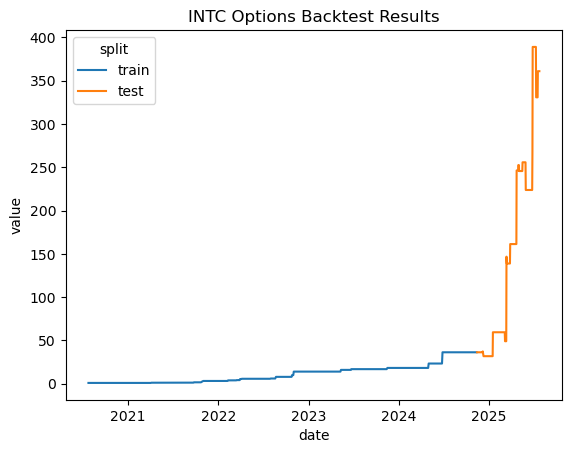

In [35]:
last_train_date = df["date"].iloc[:split_point].max()

graph_df = pd.DataFrame({"value": (1 + daily_returns).cumprod(), "split": ["test"] * len(daily_returns)})
graph_df.loc[graph_df.index <= last_train_date, "split"] = "train"
graph_df = graph_df.reset_index(names = "date")

sns.lineplot(
    data = graph_df,
    x = "date",
    y = "value",
    hue = "split",
)

plt.title(f"{TICKER} Options Backtest Results")
plt.show()